![image.png](attachment:image.png)

# Tarefa I

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.compose import ColumnTransformer

import statsmodels.formula.api as smf
import statsmodels.api as sm

from scipy.stats import ks_2samp
from scipy.stats import t
from scipy.stats import ttest_ind


import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_feather('credit_scoring.ftr')
print(df.columns)

Index(['data_ref', 'index', 'sexo', 'posse_de_veiculo', 'posse_de_imovel',
       'qtd_filhos', 'tipo_renda', 'educacao', 'estado_civil',
       'tipo_residencia', 'idade', 'tempo_emprego', 'qt_pessoas_residencia',
       'renda', 'mau'],
      dtype='object')


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   data_ref               750000 non-null  datetime64[ns]
 1   index                  750000 non-null  int64         
 2   sexo                   750000 non-null  object        
 3   posse_de_veiculo       750000 non-null  object        
 4   posse_de_imovel        750000 non-null  object        
 5   qtd_filhos             750000 non-null  int64         
 6   tipo_renda             750000 non-null  object        
 7   educacao               750000 non-null  object        
 8   estado_civil           750000 non-null  object        
 9   tipo_residencia        750000 non-null  object        
 10  idade                  750000 non-null  int64         
 11  tempo_emprego          624043 non-null  float64       
 12  qt_pessoas_residencia  750000 non-null  floa

In [5]:
df.sort_values('data_ref', inplace=True)
cutoff_date = df['data_ref'].max() - pd.DateOffset(months=3)

train_df = df[df['data_ref'] < cutoff_date].drop(columns=['data_ref', 'index'])
oot_df = df[df['data_ref'] >= cutoff_date].drop(columns=['data_ref', 'index'])

train_df = pd.get_dummies(train_df, drop_first=True)
oot_df = pd.get_dummies(oot_df, drop_first=True)

oot_df = oot_df.reindex(columns=train_df.columns, fill_value=0)

X = train_df.drop('mau', axis=1)
y = train_df['mau']
X_oot = oot_df.drop('mau', axis=1)
y_oot = oot_df['mau']

## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [6]:
num_rows = len(df)
print(f"Número de linhas: {num_rows}")

num_rows_per_month = df['data_ref'].value_counts()
print("\nNúmero de linhas para cada mês em 'data_ref':")
print(num_rows_per_month)

Número de linhas: 750000

Número de linhas para cada mês em 'data_ref':
data_ref
2015-01-01    50000
2015-02-01    50000
2015-03-01    50000
2015-04-01    50000
2015-05-01    50000
2015-06-01    50000
2015-07-01    50000
2015-08-01    50000
2015-09-01    50000
2015-10-01    50000
2015-11-01    50000
2015-12-01    50000
2016-01-01    50000
2016-02-01    50000
2016-03-01    50000
Name: count, dtype: int64


In [7]:
for col in df.columns:
    print(f"\nDescritiva básica univariada para '{col}':")
    if df[col].dtype == 'object':
        print(df[col].value_counts())
    else:
        print(df[col].describe())


Descritiva básica univariada para 'data_ref':
count                 750000
mean     2015-08-01 06:24:00
min      2015-01-01 00:00:00
25%      2015-04-01 00:00:00
50%      2015-08-01 00:00:00
75%      2015-12-01 00:00:00
max      2016-03-01 00:00:00
Name: data_ref, dtype: object

Descritiva básica univariada para 'index':
count    750000.000000
mean       8319.272793
std        4809.281774
min           0.000000
25%        4147.000000
50%        8324.000000
75%       12487.000000
max       16649.000000
Name: index, dtype: float64

Descritiva básica univariada para 'sexo':
sexo
F    504580
M    245420
Name: count, dtype: int64

Descritiva básica univariada para 'posse_de_veiculo':
posse_de_veiculo
N    457954
S    292046
Name: count, dtype: int64

Descritiva básica univariada para 'posse_de_imovel':
posse_de_imovel
S    503692
N    246308
Name: count, dtype: int64

Descritiva básica univariada para 'qtd_filhos':
count    750000.000000
mean          0.433251
std           0.739379
min   

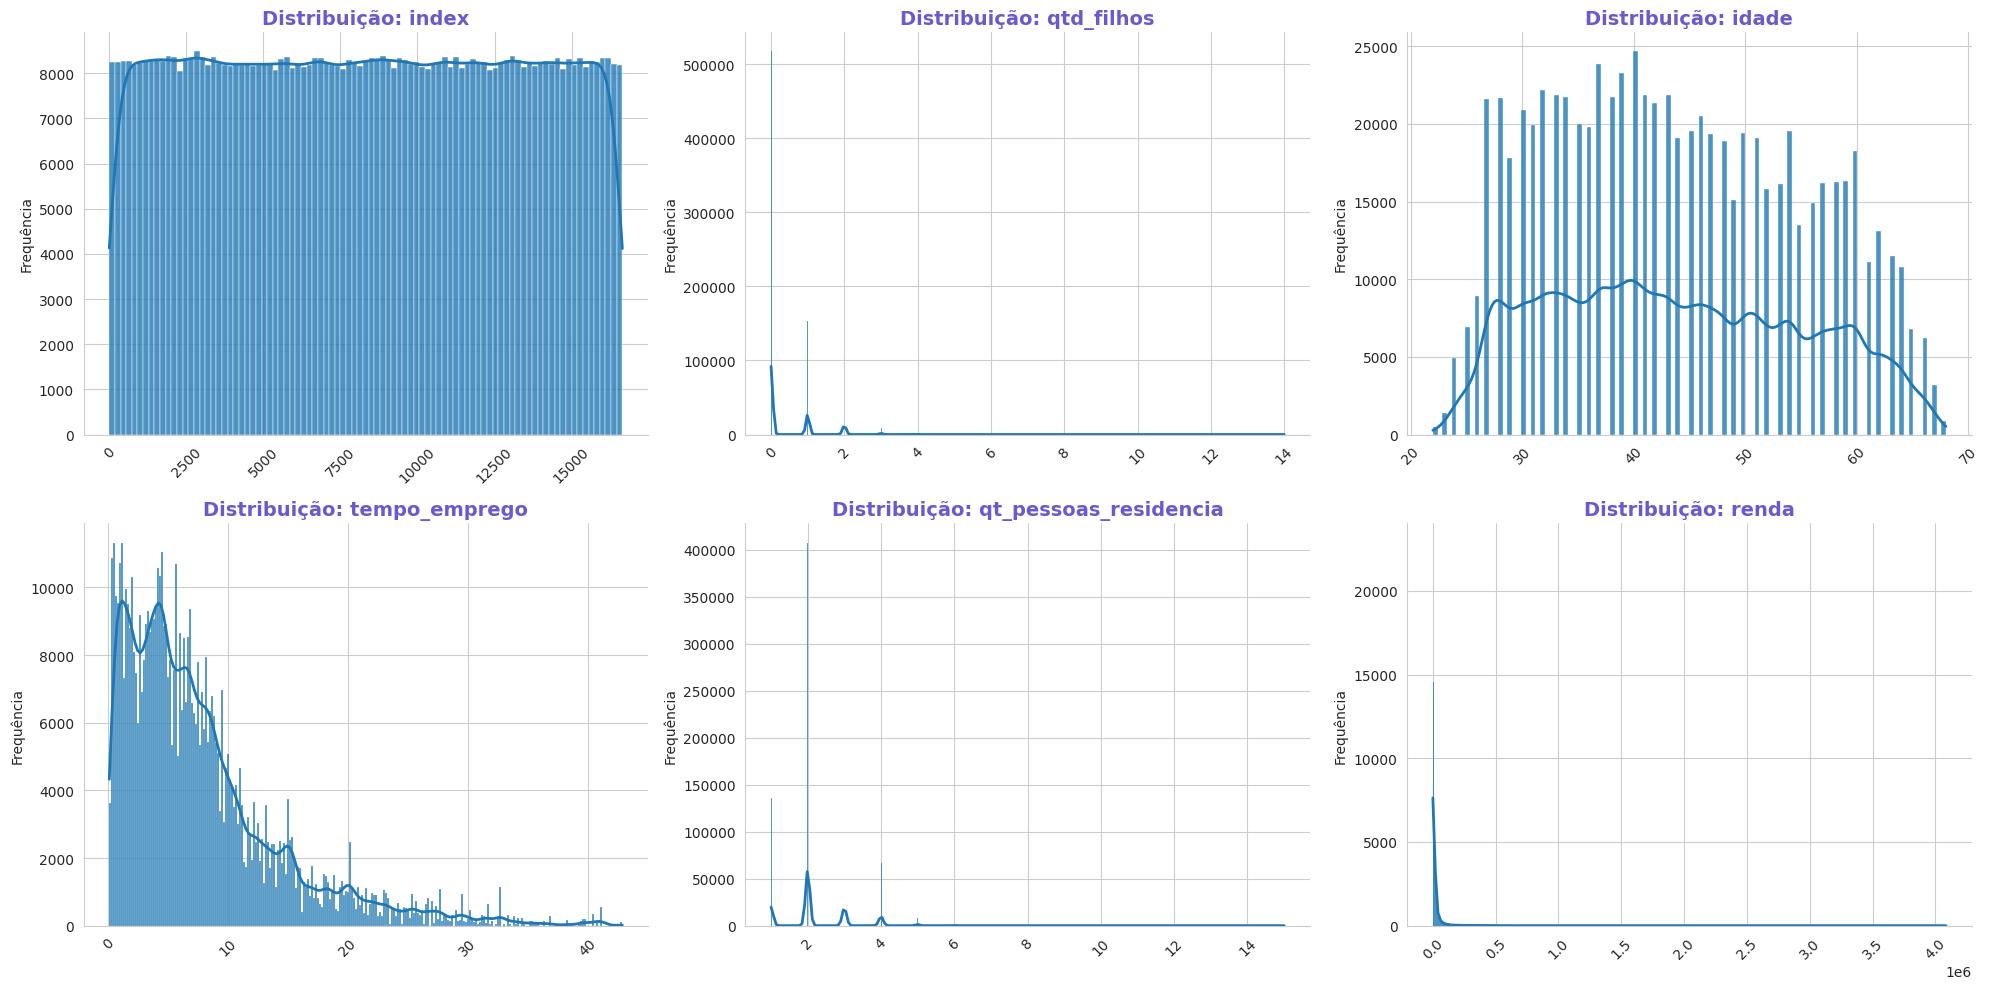

In [8]:
sns.set_style("whitegrid")

quant_vars = df.select_dtypes(include=[np.number]).columns
n_rows = int(np.ceil(len(quant_vars) / 3))

fig, axs = plt.subplots(n_rows, 3, figsize=(20, 5 * n_rows))
axs = axs.flatten()

for i, col in enumerate(quant_vars):
    sns.histplot(
        data=df,
        x=col,
        kde=True,
        ax=axs[i],
        edgecolor='white',
        line_kws={'linewidth': 2, 'color': 'darkblue'},
        alpha=0.8
    )

    axs[i].set_title(
        f'Distribuição: {col}',
        fontsize=14,
        fontweight='bold',
        color='slateblue'
    )
    axs[i].tick_params(axis='x', rotation=45)
    axs[i].set_xlabel('')
    axs[i].set_ylabel('Frequência')

    for spine in ['top', 'right']:
        axs[i].spines[spine].set_visible(False)

plt.tight_layout()
plt.show()

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

In [9]:
num_vars = ['idade', 'tempo_emprego', 'renda', 'qt_pessoas_residencia']

for col in num_vars:
    print(f"\nMédia da variável '{col}' por inadimplência (mau):")
    print(df.groupby('mau')[col].mean())


Média da variável 'idade' por inadimplência (mau):
mau
False    43.896274
True     42.725543
Name: idade, dtype: float64

Média da variável 'tempo_emprego' por inadimplência (mau):
mau
False    8.004300
True     4.695965
Name: tempo_emprego, dtype: float64

Média da variável 'renda' por inadimplência (mau):
mau
False    24804.689618
True      4774.871007
Name: renda, dtype: float64

Média da variável 'qt_pessoas_residencia' por inadimplência (mau):
mau
False    2.211221
True     2.224272
Name: qt_pessoas_residencia, dtype: float64


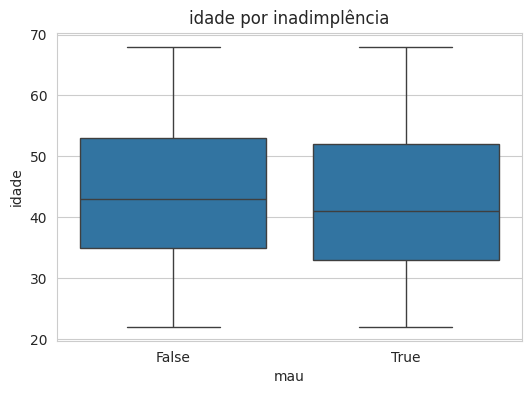

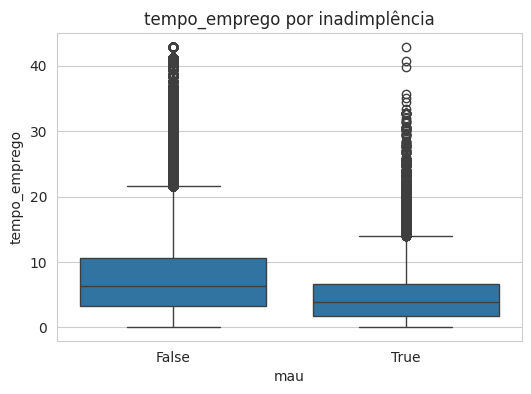

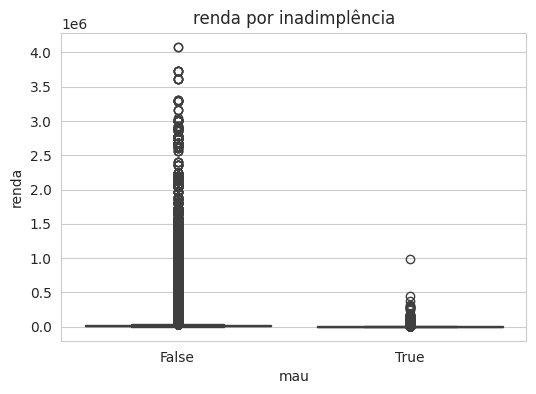

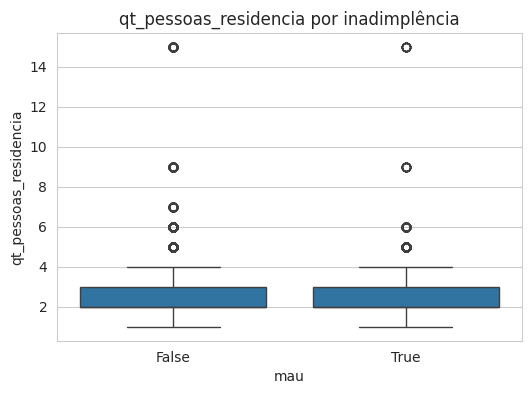

In [10]:
for col in num_vars:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='mau', y=col, data=df)
    plt.title(f'{col} por inadimplência')
    plt.show()

In [11]:
cat_vars = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda',
            'educacao', 'estado_civil', 'tipo_residencia']

for col in cat_vars:
    print(f"\nProporção de inadimplência (mau=1) por categoria de '{col}':")
    print(df.groupby(col)['mau'].mean().sort_values(ascending=False))


Proporção de inadimplência (mau=1) por categoria de 'sexo':
sexo
F    0.080522
M    0.073397
Name: mau, dtype: float64

Proporção de inadimplência (mau=1) por categoria de 'posse_de_veiculo':
posse_de_veiculo
N    0.078790
S    0.077252
Name: mau, dtype: float64

Proporção de inadimplência (mau=1) por categoria de 'posse_de_imovel':
posse_de_imovel
N    0.088479
S    0.073160
Name: mau, dtype: float64

Proporção de inadimplência (mau=1) por categoria de 'tipo_renda':
tipo_renda
Pensionista         0.082683
Assalariado         0.080917
Empresário          0.076451
Servidor público    0.058085
Bolsista            0.041551
Name: mau, dtype: float64

Proporção de inadimplência (mau=1) por categoria de 'educacao':
educacao
Fundamental            0.091662
Superior incompleto    0.082997
Médio                  0.080361
Pós graduação          0.072660
Superior completo      0.071569
Name: mau, dtype: float64

Proporção de inadimplência (mau=1) por categoria de 'estado_civil':
estado_civil
Uni


Proporção de mau por categoria de sexo:
sexo
F    0.080522
M    0.073397
Name: mau, dtype: float64


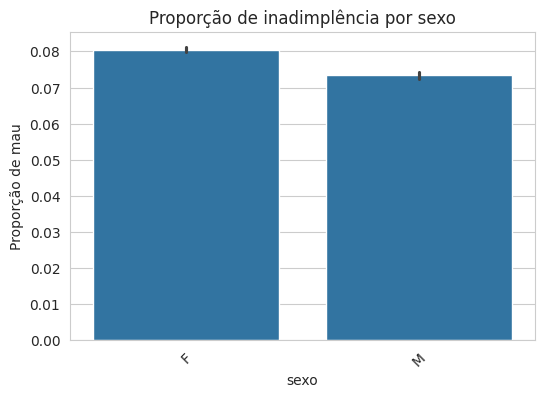


Proporção de mau por categoria de posse_de_veiculo:
posse_de_veiculo
N    0.078790
S    0.077252
Name: mau, dtype: float64


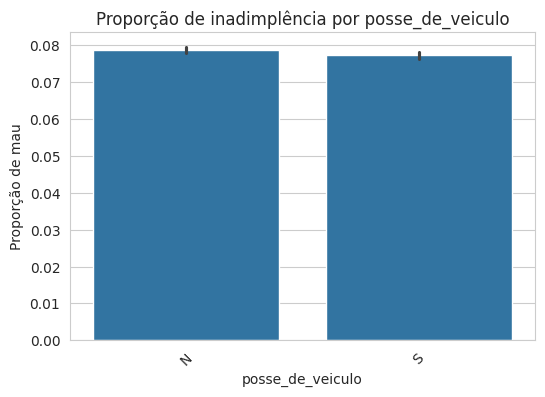


Proporção de mau por categoria de posse_de_imovel:
posse_de_imovel
N    0.088479
S    0.073160
Name: mau, dtype: float64


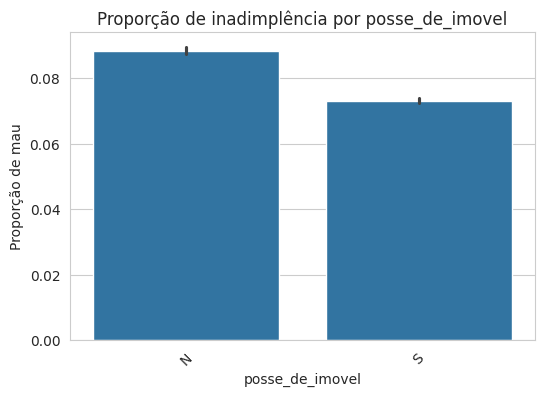


Proporção de mau por categoria de tipo_renda:
tipo_renda
Pensionista         0.082683
Assalariado         0.080917
Empresário          0.076451
Servidor público    0.058085
Bolsista            0.041551
Name: mau, dtype: float64


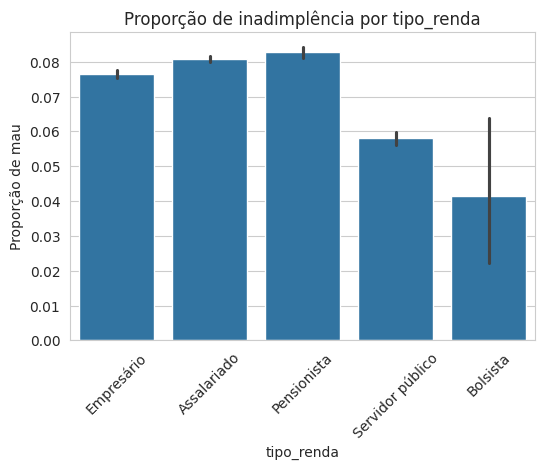


Proporção de mau por categoria de educacao:
educacao
Fundamental            0.091662
Superior incompleto    0.082997
Médio                  0.080361
Pós graduação          0.072660
Superior completo      0.071569
Name: mau, dtype: float64


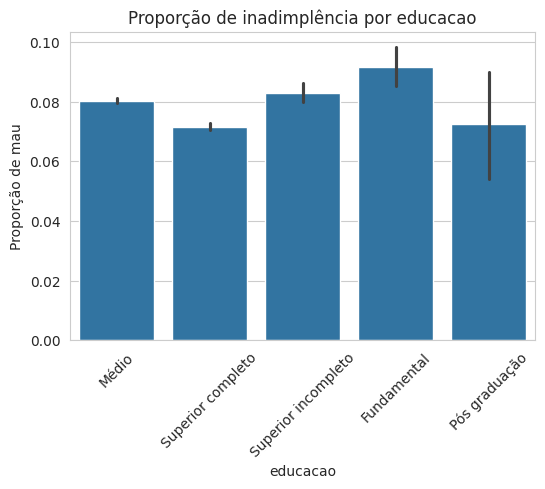


Proporção de mau por categoria de estado_civil:
estado_civil
União       0.083887
Separado    0.081769
Solteiro    0.081225
Casado      0.076963
Viúvo       0.074621
Name: mau, dtype: float64


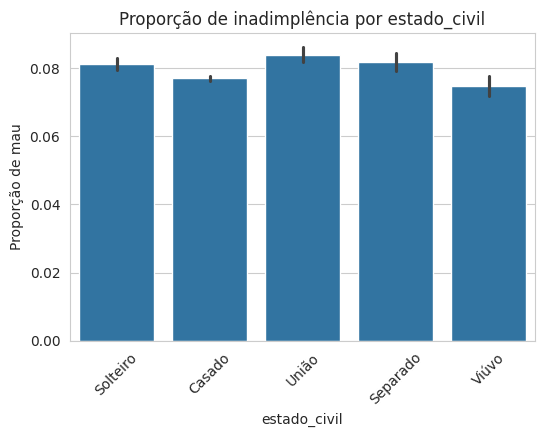


Proporção de mau por categoria de tipo_residencia:
tipo_residencia
Com os pais      0.094668
Aluguel          0.090154
Comunitário      0.084498
Governamental    0.082210
Casa             0.077127
Estúdio          0.065431
Name: mau, dtype: float64


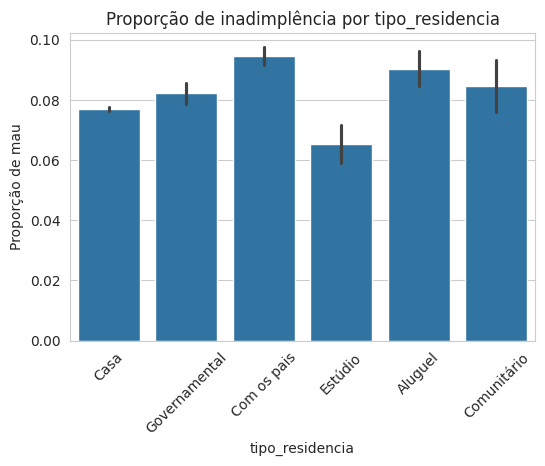

In [12]:
cat_vars = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda',
            'educacao', 'estado_civil', 'tipo_residencia']

for col in cat_vars:
    print(f"\nProporção de mau por categoria de {col}:")
    print(df.groupby(col)['mau'].mean().sort_values(ascending=False))
    plt.figure(figsize=(6,4))
    sns.barplot(x=col, y='mau', data=df, estimator=np.mean)
    plt.title(f'Proporção de inadimplência por {col}')
    plt.xticks(rotation=45)
    plt.ylabel('Proporção de mau')
    plt.show()

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_oot = scaler.transform(X_oot)

imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)
X_oot = imputer.transform(X_oot)

modelo = LogisticRegression()
modelo.fit(X_train, y_train)

LogisticRegression()

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [14]:
def calcular_metricas(nome_base, y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred > 0.5)
    ks_statistic, _ = ks_2samp(y_pred[y_true == 0], y_pred[y_true == 1])
    roc_auc = roc_auc_score(y_true, y_pred)
    gini = 2 * roc_auc - 1

    print(f'\n===== Métricas para {nome_base} =====')
    print(f'Acurácia: {accuracy:.4f}')
    print(f'KS: {ks_statistic:.4f}')
    print(f'Gini: {gini:.4f}')

In [15]:
y_pred_train = modelo.predict_proba(X_train)[:, 1]
y_pred_test = modelo.predict_proba(X_test)[:, 1]
y_pred_oot = modelo.predict_proba(X_oot)[:, 1]

calcular_metricas('Base de Desenvolvimento (Treinamento)', y_train, y_pred_train)
calcular_metricas('Base de Teste', y_test, y_pred_test)
calcular_metricas('Base Out Of Time (OOT)', y_oot, y_pred_oot)


===== Métricas para Base de Desenvolvimento (Treinamento) =====
Acurácia: 0.9423
KS: 0.3948
Gini: 0.5320

===== Métricas para Base de Teste =====
Acurácia: 0.9418
KS: 0.3900
Gini: 0.5250

===== Métricas para Base Out Of Time (OOT) =====
Acurácia: 0.8657
KS: 0.3389
Gini: 0.4585


# a - Criar um pipeline utilizando o sklearn pipeline para o preprocessamento

### Pré processamento

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

In [16]:
df = pd.read_feather('credit_scoring.ftr')
df.drop(['data_ref', 'index'], axis=1, inplace=True)

In [17]:
df.isnull().sum()

,0
sexo,0
posse_de_veiculo,0
posse_de_imovel,0
qtd_filhos,0
tipo_renda,0
educacao,0
estado_civil,0
tipo_residencia,0
idade,0
tempo_emprego,125957


In [18]:
def verifica_nulos(df):
    for coluna in df.columns:
        if df[coluna].isnull().sum() > 0:
            if df[coluna].dtype in [np.float64, np.int64]:
                df[coluna].fillna(df[coluna].mean(), inplace=True)
            else:
                df.dropna(subset=[coluna], inplace=True)
    return df


verifica_nulos(df)

,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,M,N,S,0,Empresário,Superior completo,Casado,Casa,48,3.038356,2.0,2109.99,False
749996,F,N,S,0,Pensionista,Médio,Solteiro,Casa,65,7.748574,1.0,1389.39,False
749997,M,S,N,2,Assalariado,Médio,Casado,Casa,43,10.375342,4.0,649.06,True
749998,F,N,S,0,Assalariado,Médio,Viúvo,Casa,56,13.780822,1.0,4216.72,True


### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

In [19]:
def remove_outliers_iqr(df):
    df_clean = df.copy()
    linhas_para_remover = set()

    for coluna in df_clean.select_dtypes(include=[np.number]).columns:
        q25 = np.percentile(df_clean[coluna], 25)
        q75 = np.percentile(df_clean[coluna], 75)
        iqr = q75 - q25
        limite_inferior = q25 - 1.5 * iqr
        limite_superior = q75 + 1.5 * iqr

        outliers = df_clean[(df_clean[coluna] < limite_inferior) | (df_clean[coluna] > limite_superior)].index
        linhas_para_remover.update(outliers)

    df_clean = df_clean.drop(index=linhas_para_remover)

    return df_clean

In [20]:
print(f'Antes de remover outliers: {df.shape}')
df = remove_outliers_iqr(df)
print(f'Depois de remover outliers: {df.shape}')

Antes de remover outliers: (750000, 13)
Depois de remover outliers: (643124, 13)


In [21]:
def substituir_outliers_iqr(df):
    df_corrigido = df.copy()

    for coluna in df_corrigido.select_dtypes(include=[np.number]).columns:
        q25 = np.percentile(df_corrigido[coluna], 25)
        q75 = np.percentile(df_corrigido[coluna], 75)
        iqr = q75 - q25

        limite_inferior = q25 - 1.5 * iqr
        limite_superior = q75 + 1.5 * iqr

        df_corrigido.loc[df_corrigido[coluna] < limite_inferior, coluna] = limite_inferior

        df_corrigido.loc[df_corrigido[coluna] > limite_superior, coluna] = limite_superior

    return df_corrigido

In [22]:
print(f'Antes de tratar outliers: {df.describe()}')
df = substituir_outliers_iqr(df)
print(f'Depois de tratar outliers: {df.describe()}')

Antes de tratar outliers:          qtd_filhos          idade  tempo_emprego  qt_pessoas_residencia  \
count  643124.00000  643124.000000  643124.000000          643124.000000   
mean        0.40293      43.459961       6.149261               2.180482   
std         0.65641      11.565668       3.634897               0.834370   
min         0.00000      22.000000       0.117808               1.000000   
25%         0.00000      34.000000       3.243836               2.000000   
50%         0.00000      42.000000       6.515068               2.000000   
75%         1.00000      53.000000       7.748574               3.000000   
max         2.00000      68.000000      17.268493               4.000000   

               renda  
count  643124.000000  
mean     9450.510117  
std      8628.818083  
min       107.670000  
25%      3074.065000  
50%      6446.370000  
75%     13063.540000  
max     40591.590000  
Depois de tratar outliers:          qtd_filhos          idade  tempo_emprego  qt_p

### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance?

In [23]:
def seleciona_variaveis(df, target, n_top=8, random_state=42):
    X = df.drop(columns=[target])
    y = df[target]

    X = pd.get_dummies(X, drop_first=True)

    model = RandomForestClassifier(random_state=random_state)
    model.fit(X, y)

    importancias = pd.Series(model.feature_importances_, index=X.columns)
    importancias_ordenadas = importancias.sort_values(ascending=False)

    top_features = importancias_ordenadas.head(n_top)

    print(f"\nTop {n_top} variáveis mais importantes:\n")
    print(top_features)

    return top_features

In [24]:
top_variaveis = seleciona_variaveis(df, target='mau', n_top=10)


Top 10 variáveis mais importantes:

renda                    0.747027
tempo_emprego            0.090735
idade                    0.081601
qt_pessoas_residencia    0.009671
posse_de_veiculo_S       0.008860
tipo_renda_Empresário    0.007261
posse_de_imovel_S        0.006839
sexo_M                   0.006675
qtd_filhos               0.006673
estado_civil_União       0.004743
dtype: float64


### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

In [25]:
def aplicar_pca(df, target, n_componentes=5):
    X = df.drop(columns=[target])
    y = df[target]

    X = pd.get_dummies(X, drop_first=True)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    pca = PCA(n_components=n_componentes)
    X_pca = pca.fit_transform(X_scaled)

    colunas = [f'PC{i+1}' for i in range(n_componentes)]
    pca_df = pd.DataFrame(X_pca, columns=colunas)

    pca_df[target] = y.values

    return pca_df

In [26]:
pca_resultado = aplicar_pca(df, target='mau', n_componentes=5)
print(pca_resultado.head())

        PC1       PC2       PC3       PC4       PC5    mau
0 -1.031499  1.535594  0.348513 -2.377775  0.198704  False
1 -0.116318 -0.366401 -0.559740 -1.044509  0.216823  False
2  2.070803 -1.326409 -1.981615 -0.562874 -2.166072  False
3 -1.454698 -0.309446 -0.573729  0.835573  0.396896  False
4  0.423267  1.826796  1.927342 -1.907086  0.757036  False


### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1.
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

In [27]:
def aplicar_dummies_selecionadas(df, colunas):
    return pd.get_dummies(df, columns=colunas, drop_first=True)

In [28]:
colunas_categoricas = [
    'sexo', 'posse_de_veiculo', 'posse_de_imovel',
    'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia'
]

df = aplicar_dummies_selecionadas(df, colunas_categoricas)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 643124 entries, 0 to 749999
Data columns (total 26 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   qtd_filhos                     643124 non-null  float64
 1   idade                          643124 non-null  float64
 2   tempo_emprego                  643124 non-null  float64
 3   qt_pessoas_residencia          643124 non-null  float64
 4   renda                          643124 non-null  float64
 5   mau                            643124 non-null  bool   
 6   sexo_M                         643124 non-null  bool   
 7   posse_de_veiculo_S             643124 non-null  bool   
 8   posse_de_imovel_S              643124 non-null  bool   
 9   tipo_renda_Bolsista            643124 non-null  bool   
 10  tipo_renda_Empresário          643124 non-null  bool   
 11  tipo_renda_Pensionista         643124 non-null  bool   
 12  tipo_renda_Servidor público    6431

### Pipeline

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [29]:
def criar_dummy_seguro(df):
    df = df.copy()
    if 'posse_de_veiculo' in df.columns:
        df = pd.get_dummies(df, columns=['posse_de_veiculo'], drop_first=True)
    return df

def substituir_outliers_iqr(df):
    df_corrigido = df.copy()
    for coluna in df_corrigido.select_dtypes(include=[np.number]).columns:
        q25 = np.percentile(df_corrigido[coluna], 25)
        q75 = np.percentile(df_corrigido[coluna], 75)
        iqr = q75 - q25
        limite_inferior = q25 - 1.5 * iqr
        limite_superior = q75 + 1.5 * iqr
        df_corrigido[coluna] = np.where(df_corrigido[coluna] < limite_inferior, limite_inferior, df_corrigido[coluna])
        df_corrigido[coluna] = np.where(df_corrigido[coluna] > limite_superior, limite_superior, df_corrigido[coluna])
    return df_corrigido

In [30]:
pipeline_corrigido = Pipeline(steps=[
    ('criar_dummy', FunctionTransformer(criar_dummy_seguro)),
    ('remover_outliers', FunctionTransformer(substituir_outliers_iqr)),
    ('imputacao', SimpleImputer(strategy='mean')),
    ('padronizacao', StandardScaler()),
    ('pca', PCA(n_components=5))
])

In [31]:
X = df.drop(columns=['mau'])
y = df['mau']

X_transformado = pipeline_corrigido.fit_transform(X)

colunas = [f'PC{i+1}' for i in range(5)]
df_pca = pd.DataFrame(X_transformado, columns=colunas)
df_pca.head()

,PC1,PC2,PC3,PC4,PC5
0,-1.029612,1.559909,0.351724,-2.331390,0.064672
1,-0.118576,-0.367230,-0.576409,-1.100105,0.170850
2,2.074036,-1.295857,-1.975598,-0.542641,-2.206553
3,-1.453773,-0.264847,-0.576612,0.837072,0.298746
4,0.409769,1.830086,1.925125,-1.842682,0.549912


# b - Pycaret na base de dados

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [32]:
df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [33]:
dataset = df.sample(50000)
dataset.drop(['data_ref', 'index'], axis=1, inplace=True)

In [34]:
data = dataset.sample(frac=0.95, random_state=786)
data_unseen = dataset.drop(data.index)

data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)

print('Conjunto de dados para modelagem (treino/teste):', data.shape)
print('Conjunto de dados não usados no treino/teste (validação final):', data_unseen.shape)

Conjunto de dados para modelagem (treino/teste): (47500, 13)
Conjunto de dados não usados no treino/teste (validação final): (2500, 13)


In [36]:
from pycaret.classification import *

exp_clf101 = setup(data=data, target='mau', session_id=123, use_gpu=False)

,Description,Value
0,Session id,123
1,Target,mau
2,Target type,Binary
3,Original data shape,"(47500, 13)"
4,Transformed data shape,"(47500, 30)"
5,Transformed train set shape,"(33250, 30)"
6,Transformed test set shape,"(14250, 30)"
7,Numeric features,5
8,Categorical features,7
9,Rows with missing values,16.8%


In [37]:
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [38]:
lgbm = create_model('lightgbm', fix_imbalance=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9221,0.7545,0.0385,0.5263,0.0717,0.0617,0.1265
1,0.9236,0.7622,0.0423,0.6875,0.0797,0.0713,0.1578
2,0.9212,0.7761,0.0268,0.4667,0.0507,0.0426,0.0972
3,0.9194,0.7368,0.0153,0.2667,0.0290,0.0206,0.0471
4,0.9224,0.7520,0.0460,0.5714,0.0851,0.0743,0.1461
5,0.9212,0.7749,0.0307,0.4706,0.0576,0.0484,0.1045
6,0.9224,0.7613,0.0460,0.5714,0.0851,0.0743,0.1461
7,0.9221,0.7569,0.0383,0.5556,0.0717,0.0622,0.1309
8,0.9194,0.7608,0.0345,0.3600,0.0629,0.0499,0.0911


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [39]:
tuned_lgbm = tune_model(lgbm, optimize='F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9074,0.7238,0.0615,0.2000,0.0941,0.0595,0.0712
1,0.9065,0.7343,0.0808,0.2258,0.1190,0.0811,0.0933
2,0.9053,0.7273,0.0613,0.1860,0.0922,0.0555,0.0652
3,0.9101,0.7164,0.0613,0.2286,0.0967,0.0657,0.0818
4,0.9110,0.7036,0.0728,0.2603,0.1138,0.0823,0.1013
5,0.9068,0.7238,0.0766,0.2247,0.1143,0.0775,0.0902
6,0.9104,0.7040,0.0575,0.2239,0.0915,0.0614,0.0775
7,0.9119,0.7180,0.1034,0.3140,0.1556,0.1214,0.1427
8,0.9098,0.7339,0.0805,0.2593,0.1228,0.0889,0.1062


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


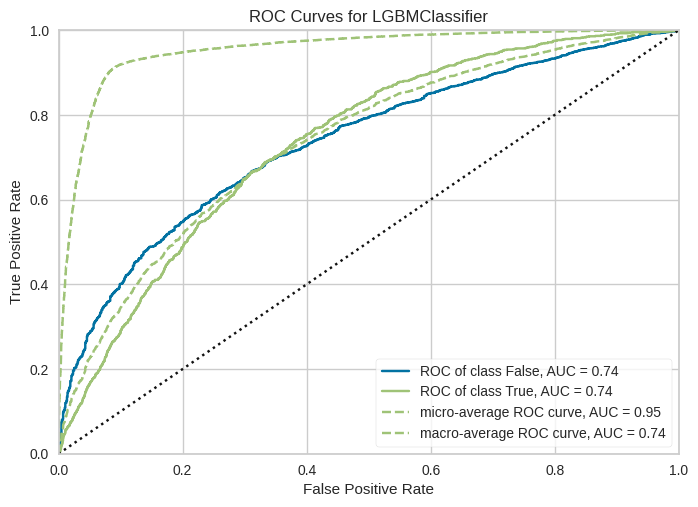

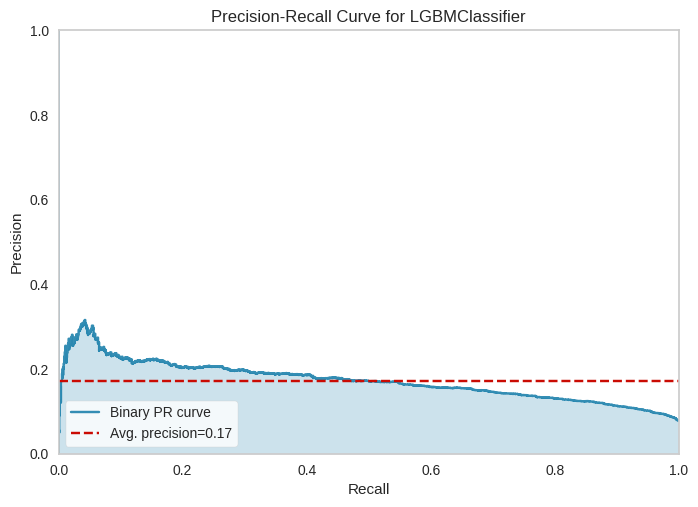

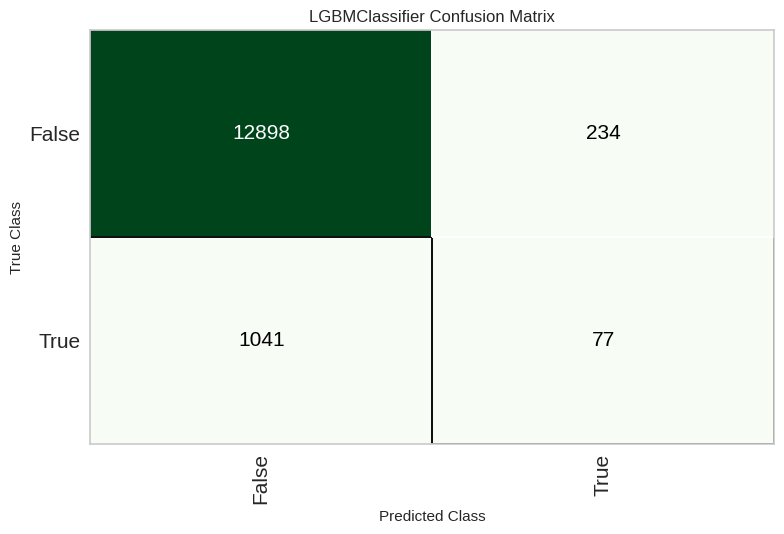

In [40]:
plot_model(tuned_lgbm, plot='auc')
plot_model(tuned_lgbm, plot='pr')
plot_model(tuned_lgbm, plot='confusion_matrix')

In [41]:
predict_model(tuned_lgbm)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9105,0.7356,0.0689,0.2476,0.1078,0.0762,0.0940


[LightGBM] [Warning] Unknown parameter: fix_imbalance
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] Unknown parameter: fix_imbalance
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,prediction_label,prediction_score
30530,F,S,S,1,Pensionista,Médio,Casado,Casa,56,NaN,3.0,5138.029785,False,0,0.9042
36030,M,S,S,0,Empresário,Superior incompleto,Solteiro,Casa,31,1.038356,1.0,8554.309570,False,0,0.9897
44150,M,S,N,0,Pensionista,Médio,Casado,Casa,51,NaN,2.0,1560.380005,False,0,0.8758
18953,F,N,S,2,Assalariado,Médio,Casado,Casa,42,1.961644,4.0,2176.040039,False,0,0.9071
19098,F,N,S,0,Empresário,Médio,Solteiro,Casa,36,1.043836,1.0,1020.969971,False,0,0.8109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16231,F,N,S,0,Assalariado,Médio,Casado,Casa,27,6.846575,2.0,3924.389893,False,0,0.9561
10273,F,S,S,1,Servidor público,Médio,Casado,Casa,37,4.046576,3.0,2704.159912,False,0,0.9435
9463,F,N,S,1,Assalariado,Superior completo,Casado,Casa,34,6.383562,3.0,2656.000000,False,0,0.8734
16473,M,S,N,0,Empresário,Superior completo,Casado,Casa,51,3.621918,2.0,11057.780273,False,0,0.9790


In [42]:
final_lgbm = finalize_model(tuned_lgbm)

In [43]:
unseen_predictions = predict_model(final_lgbm, data=data_unseen)
unseen_predictions.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9144,0.7369,0.0570,0.2558,0.0932,0.0670,0.0885


[LightGBM] [Warning] Unknown parameter: fix_imbalance
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] Unknown parameter: fix_imbalance
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,prediction_label,prediction_score
0,F,N,N,0,Pensionista,Médio,Casado,Casa,59,NaN,2.0,5913.129883,False,0,0.9307
1,F,N,S,0,Assalariado,Médio,Casado,Casa,54,10.926027,2.0,24069.570312,False,0,0.9799
2,F,S,S,0,Pensionista,Médio,Casado,Casa,64,NaN,2.0,8630.120117,False,0,0.9606
3,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,4.624658,2.0,36707.550781,False,0,0.9958
4,F,N,S,0,Pensionista,Médio,Solteiro,Casa,55,NaN,1.0,1098.780029,False,0,0.7472


In [44]:
save_model(final_lgbm, 'Final_LGBM_Model_6jul2025')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['qtd_filhos', 'idade',
                                              'tempo_emprego',
                                              'qt_pessoas_residencia', 'renda'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean'))),
                 ('categorical_imputer',
                  TransformerWra...
                                 colsample_bytree=1.0, feature_fraction=0.5,
         